In [2]:
# from __future__ import absolute_import
# from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import pandas as pd

import random
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Lambda, Input, merge
from keras.optimizers import SGD, RMSprop
from keras import backend as K

from sklearn.model_selection import train_test_split
from keras.applications import inception_v3
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from random import shuffle
from scipy.misc import imresize
from skimage.transform import resize

import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 299
N_TRAINABLE = 18
N_EPOCH = 10
# DATA_DIR = "./data"
# IMAGE_DIR = os.path.join(DATA_DIR, "train_processed")


In [4]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


### Create pairs data

In [5]:
# generate list of pairs: (filename1, filename2, 1-same/0-different)
def create_pairs(train_df, N=50000):
    '''
    pairs : alternating between positive and negative pairs (img1_filename, img2_filename, 1/0)
    Drawing randomly from the identified whale IDs
    then randomly sample from all images belong to that ID 
    If only one image available for that ID, use the same image filename ("*.jpg")
    This is relying on the augmentor to make sure two inputs are different
    '''
    pairs = []
    # list of identified whale IDs without "new_whale"
    pool_df = train_df[train_df['Id']!='new_whale']
    counts = pool_df['Id'].value_counts()
    ID_pool = list(counts.keys())
    num_ID = len(ID_pool)

    for i in range(N):
                
        inds = np.random.choice(num_ID, 3, replace=False)
        # positive pair: randomly sample 1 ID from id_pool
        # then randomly sample 2 images from that ID's available images with replacement
        imgnames = list(pool_df[pool_df['Id']==ID_pool[inds[0]]].sample(n=2, replace=True)['Image'])
        pairs.append((imgnames[0],imgnames[1],1))
        
        # negative pair: randomly sample 2 IDs from id_pool without replacement
        # then randomly sample 1 image from each ID's available images
        imgnames1 = list(pool_df[pool_df['Id']==ID_pool[inds[1]]].sample(n=1, replace=True)['Image'])
        imgnames2 = list(pool_df[pool_df['Id']==ID_pool[inds[2]]].sample(n=1, replace=True)['Image'])
        pairs.append((imgnames1[0],imgnames2[0],0))
        
        if i % 1000 == 999:
            print('Generated {:d} of {:d} pairs'.format((i+1)*2, N*2))  
    return pairs
            
pairs_data = create_pairs(train_df)

print(len(pairs_data))
print(pairs_data[0:5])

Generated 2000 of 100000 pairs
Generated 4000 of 100000 pairs
Generated 6000 of 100000 pairs
Generated 8000 of 100000 pairs
Generated 10000 of 100000 pairs
Generated 12000 of 100000 pairs
Generated 14000 of 100000 pairs
Generated 16000 of 100000 pairs
Generated 18000 of 100000 pairs
Generated 20000 of 100000 pairs
Generated 22000 of 100000 pairs
Generated 24000 of 100000 pairs
Generated 26000 of 100000 pairs
Generated 28000 of 100000 pairs
Generated 30000 of 100000 pairs
Generated 32000 of 100000 pairs
Generated 34000 of 100000 pairs
Generated 36000 of 100000 pairs
Generated 38000 of 100000 pairs
Generated 40000 of 100000 pairs
Generated 42000 of 100000 pairs
Generated 44000 of 100000 pairs
Generated 46000 of 100000 pairs
Generated 48000 of 100000 pairs
Generated 50000 of 100000 pairs
Generated 52000 of 100000 pairs
Generated 54000 of 100000 pairs
Generated 56000 of 100000 pairs
Generated 58000 of 100000 pairs
Generated 60000 of 100000 pairs
Generated 62000 of 100000 pairs
Generated 64

### Load training images into array, formatted by InceptionV3 input requirement

In [6]:
#load all training images (9850 total) to one array to speed up

def load_image_cache(image_cache, image_filename):
    img = plt.imread('./data/train_processed/'+image_filename)
    img = np.stack((img,img,img),axis=2)
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    image_cache[image_filename] = img
    
    
image_cache = {}
filenames = list(train_df['Image'])
for i in range(len(filenames)):
    if i % 1000 == 999:
        print('{:d}/{:d} images loaded'.format(i+1, len(filenames)))
    load_image_cache(image_cache, filenames[i])
print('{:d}/{:d} images loaded'.format(i+1, len(filenames)))


/Applications/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1000/9850 images loaded
2000/9850 images loaded
3000/9850 images loaded
4000/9850 images loaded
5000/9850 images loaded
6000/9850 images loaded
7000/9850 images loaded
8000/9850 images loaded
9000/9850 images loaded
9850/9850 images loaded


### Prepare input data with augmentation

In [46]:
# make image generator with augmented pairs
def pair_generator(pairs, image_cache, datagens, batch_size=128):
    '''
    pairs : positive and negative pairs (img1_filename, img2_filename, 1/0)
    image_cache : loaded image files in correct format for all filenames
    datagens : augmentor
    '''
    while True:
        # shuffle once per epoch
        indices = np.random.permutation(np.arange(len(pairs)))
        num_batches = len(pairs) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [pairs[i] for i in batch_indices]
            X1 = np.zeros((batch_size, 299, 299, 3))
            X2 = np.zeros((batch_size, 299, 299, 3))
            Y = np.zeros((batch_size, 1))
            for i, (image_filename1, image_filename2, label) in enumerate(batch):
                if datagens is None or len(datagens) == 0:
                    X1[i] = image_cache[image_filename1]
                    X2[i] = image_cache[image_filename2]
                else:
                    X1[i] = datagens[0].random_transform(image_cache[image_filename1])
                    X2[i] = datagens[1].random_transform(image_cache[image_filename2])
                Y[i] = label
            # convert input data to required format by inceptionV3
            X1 = inception_v3.preprocess_input(np.array(X1, dtype="float32"))
            X2 = inception_v3.preprocess_input(np.array(X2, dtype="float32"))
            yield [X1, X2], Y

datagen_args = dict(rotation_range=5,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2)
# datagen_args = dict(featurewise_center=False, 
#                     samplewise_center=False, 
#                     featurewise_std_normalization=False, 
#                     samplewise_std_normalization=False, 
#                     zca_whitening=False, 
#                     zca_epsilon=1e-06, 
#                     rotation_range=5, 
#                     width_shift_range=0.1, 
#                     height_shift_range=0.1, 
#                     brightness_range=(0.75,1.5), 
#                     shear_range=0, 
#                     zoom_range=0.2, 
#                     channel_shift_range=0, 
#                     fill_mode='nearest', 
#                     cval=0.0, 
#                     horizontal_flip=False, 
#                     vertical_flip=False, 
#                     rescale=None, 
#                     preprocessing_function=None, 
#                     data_format=None, 
#                     validation_split=0.0)
datagens = [ImageDataGenerator(**datagen_args),
            ImageDataGenerator(**datagen_args)]
# pair_gen = pair_generator(pairs_data, image_cache, datagens, 32)
# [X1, X2], Y = next(pair_gen)
# print(X1.shape, X2.shape, Y.shape)

In [47]:
pair_gen = pair_generator(pairs_data, image_cache, datagens, 4)
[X1, X2], Y = next(pair_gen)
print(X1.shape, X2.shape, Y.shape)

(4, 299, 299, 3) (4, 299, 299, 3) (4, 1)


In [9]:
pairs_data_train, pairs_data_val = train_test_split(pairs_data, train_size=0.8)

train_pair_gen = pair_generator(pairs_data_train, image_cache, datagens, BATCH_SIZE)
val_pair_gen = pair_generator(pairs_data_val, image_cache, None, BATCH_SIZE)



/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Define network functions

In [10]:
# def euclidean_distance(vects):
#     x, y = vects
#     return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)

def manhattan_distance(vects):
    x, y = vects
    return (K.sum(K.abs(x - y), axis=1, keepdims=True))


def manh_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true,y_pred):
    '''
    y * 0.5 * D^2 + (1-y) * 0.5 * max(0, margin-D)^2
    y_true: 1-same
    y_true: 0-different
    y_pred: the distance between the two embeddings
    '''
    margin = 30
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


### Build Siamese Network

In [11]:
# network definition
base_network = inception_v3.InceptionV3(weights="imagenet", include_top=False, pooling='avg')
base_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
base_network.output_shape

(None, 2048)

In [13]:
for layer in base_network.layers[:-N_TRAINABLE]:
    layer.trainable = False
for layer in base_network.layers[-N_TRAINABLE:]:
    layer.trainable = True
base_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
input_a = Input(shape=(299,299,3,))
input_b = Input(shape=(299,299,3,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(manhattan_distance, output_shape=manh_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  if sys.path[0] == '':


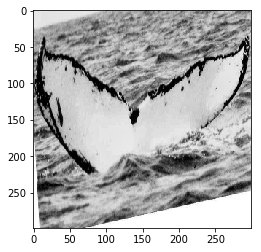

In [62]:
plt.imshow(image_cache['3ae556d3.jpg'],cmap='gray')

In [65]:
img1=datagens[0].random_transform(image_cache['3ae556d3.jpg'])

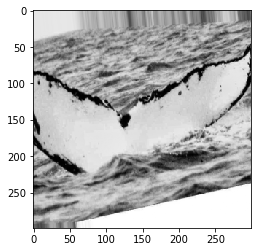

In [66]:
plt.imshow(img1,cmap='gray')

In [48]:
vecs = base_network.predict(X1)

In [49]:
vecs[0]

array([0.02768448, 0.13550662, 0.14083977, ..., 0.18184969, 0.10135736,
       0.        ], dtype=float32)

In [17]:
img = plt.imread('./data/train_processed/'+'3ae556d3.jpg')
img = np.stack((img,img,img),axis=2)
img = resize(img, (IMAGE_SIZE, IMAGE_SIZE))
# img = inception_v3.preprocess_input(np.array([img], dtype="float32"))
img = inception_v3.preprocess_input(np.array([img], dtype="float32"))


/Applications/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [18]:
img.shape

(1, 299, 299, 3)

In [19]:
vec = base_network.predict([img])

In [20]:
vec

array([[0.01890941, 0.0452674 , 0.11877923, ..., 0.13548188, 0.16311839,
        0.        ]], dtype=float32)

In [169]:
train_vecs = pd.read_pickle('train_vecs.pkl')

In [170]:
train_vecs.head()

,name,vec,label
0,00022e1a.jpg,"[0.0, 0.40396255254745483, 0.23073887825012207...",w_e15442c
1,000466c4.jpg,"[0.0, 0.40127861499786377, 0.2082851231098175,...",w_1287fbc
2,00087b01.jpg,"[0.0, 0.39454972743988037, 0.22640979290008545...",w_da2efe0
3,001296d5.jpg,"[0.0, 0.3986162543296814, 0.22212862968444824,...",w_19e5482
4,0014cfdf.jpg,"[0.0, 0.4057381749153137, 0.21147847175598145,...",w_f22f3e3


In [171]:
train_vecs[train_vecs.name == '3ae556d3.jpg']

,name,vec,label
2274,3ae556d3.jpg,"[0.0, 0.4001004993915558, 0.20454242825508118,...",w_983829b


TypeError: Invalid dimensions for image data

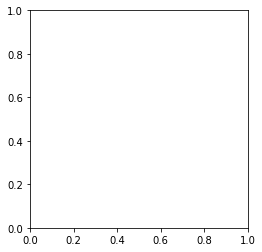

In [184]:
plt.imshow(img, cmap='gray')

In [74]:
y_true = Y
y_pred = Y_pred
margin=30
np.mean(y_true * np.square(y_pred) + (1 - y_true) * np.square(np.max(margin - y_pred, 0)))

1084.1474781036377

In [69]:
Y

array([[1.],
       [0.],
       [0.],
       [0.]])

In [56]:
Y_pred = model.predict([X1,X2])

In [57]:
Y_pred.shape

(4, 1)

In [58]:
Y_pred

array([[ 63.40418 ],
       [ 40.578995],
       [ 40.27132 ],
       [130.6076  ]], dtype=float32)

In [70]:
contrastive_loss(Y,Y_pred)

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [59]:
# train
num_train_steps = len(pairs_data_train) // BATCH_SIZE
num_val_steps = len(pairs_data_val) // BATCH_SIZE

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit_generator(train_pair_gen,
                    steps_per_epoch=num_train_steps,
                    epochs=N_EPOCH,
                    validation_data=val_pair_gen,
                    validation_steps=num_val_steps)


Epoch 1/10
  2/625 [..............................] - ETA: 9:50:51 - loss: 83418.8477 

KeyboardInterrupt: 

In [107]:
base_network.output

20000

In [ ]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))